In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
from torch.distributions import Categorical
import matplotlib.pyplot as plt

#hyperparameter
learning_rate = 1e-4
gamma = 0.99
episodes = 2000

In [2]:
class policy_model(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(policy_model, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        self.memory = deque([])

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        prob = F.softmax(self.layer3(x))
        return prob

    def optimization(self):
        self.optimizer.zero_grad()
        R = 0
        step = 0
        while self.memory:
            r, prob = self.memory.pop()

            R += (gamma ** (step)) * r 
            # R = r + gamma * R
            
            cost = - R * torch.log(prob) # 경사 상승이니 - 필요 
            cost.backward()
            
            step += 1

        self.optimizer.step()
        self.memory = deque([])

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(score_list,show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
        

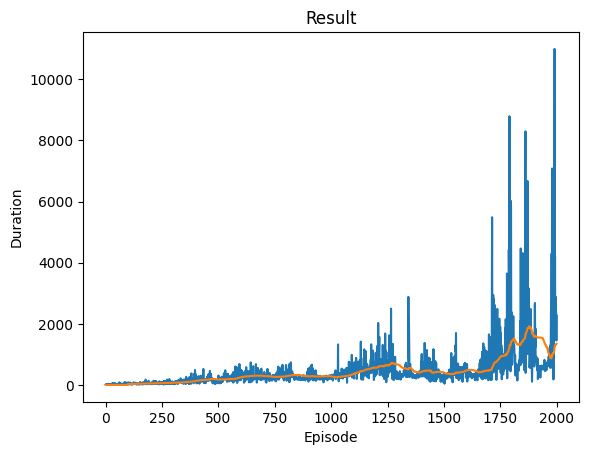

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
env = gym.make('CartPole-v1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = policy_model(env.observation_space.shape[0], env.action_space.n).to(device)
score = 0
print_interval = 20
score_list = []

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    score = 0
    while not done:
        probs = policy_net(torch.tensor(state, device=device))
        # print(torch.tensor(state, device=device), torch.from_numpy(np.asarray(state)).float())
        distribution = Categorical(probs)
        action = distribution.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done
        state = next_state

        policy_net.memory.append((reward, probs[action]))

        score += reward
        
        if done:
            score_list.append(score + 1)
            plot_durations(score_list)
            break
    
    policy_net.optimization()

    env.close()

plot_durations(score_list, show_result=True)
plt.ioff()
plt.show()

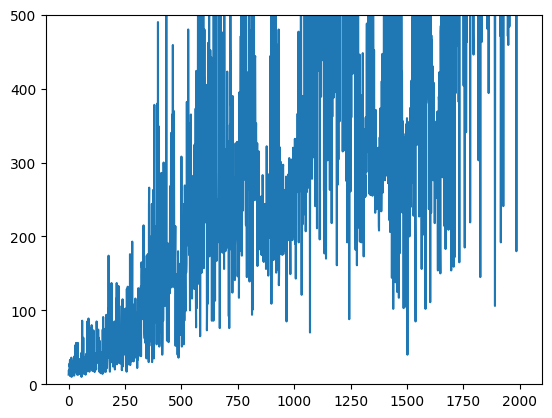

In [4]:
plot_durations(score_list)

plt.plot(score_list)
plt.ylim(0,500)
plt.show()